**Implemented by: Anika Shrivastava**

## **important imports**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import random
import cv2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Input, LeakyReLU, Add, Concatenate, concatenate
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import load_model
import math
import pandas as pd
#import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### **drive mounted**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **reading the images**

In [ ]:
def read(path):
    path = path
    dataset = []

    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(path, filename)
            img = image.load_img(image_path,target_size=(256,256,3),color_mode= 'rgb')
            img=image.img_to_array(img)
            img=img/255
            dataset.append(img)
    dataset= np.array(dataset)
    return dataset

### **Dataset BSDS300 can be accessed from the link: https://www.kaggle.com/datasets/adheshgarg/bsds300**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/BSDS300_all'    # change the path accrodingly
dataset = read(path)

In [ ]:
dataset.shape

(300, 256, 256, 3)

In [ ]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(256,256,3))
    plt.show()

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 10 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
train=dataset[0:150]
val=dataset[150:200]
test= dataset[200:300]

## **Experiment-7 (Analyzing the impact of adding 1x1 Conv layer in 32x32x8 , 16x16x8, 8x8x8 models)**

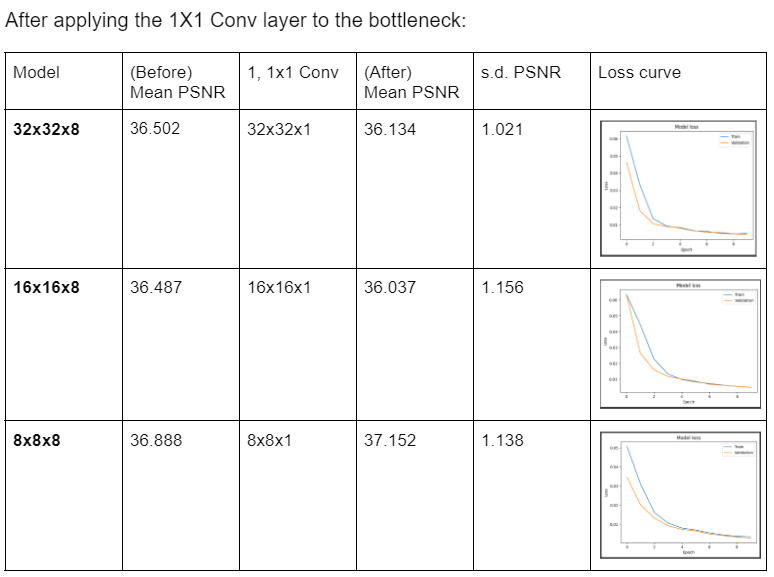

## 32x32x8 with 1x1 Conv layer
(32x32x1 : 1,024 in bottleneck)

In [ ]:
# Input layer for 256x256x3 images
input_img = Input(shape=(256, 256, 3))

# Encoder
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
# p1 = Dropout(0.3)(x1)
p1 = MaxPooling2D((2, 2), padding='same')(x1)


x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# p2 = Dropout(0.3)(x2)
p2 = MaxPooling2D((2, 2), padding='same')(x2)


x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
x3 = Conv2D(8, (3, 3), activation='relu', padding='same')(x3)
encoded = MaxPooling2D((2, 2), padding='same')(x3)

# 1x1 Conv layer
x1x1= Conv2D(1,(1,1),activation='relu',padding='same')(encoded)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x1x1)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x3], axis=-1)  # Adding skip connection
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x2], axis=-1)  # Adding skip connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x1], axis=-1)  # Adding skip connection
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# This model maps an input to its reconstruction
autoencoder14 = Model(input_img, decoded)
autoencoder14.compile(optimizer='adam', loss='mse')
autoencoder14.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 256, 256, 32)         896       ['input_4[0][0]']             
                                                                                                  
 conv2d_37 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_36[0][0]']           
                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 128, 128, 32)         0         ['conv2d_37[0][0]']           
 ng2D)                                                                                      

In [ ]:
history= autoencoder14.fit(train, train, epochs=10, batch_size=12, validation_data=(val, val))

Epoch 1/10
13/13 [==============================] - 197s 15s/step - loss: 0.0594 - val_loss: 0.0558
Epoch 2/10
13/13 [==============================] - 123s 9s/step - loss: 0.0350 - val_loss: 0.0251
Epoch 3/10
13/13 [==============================] - 132s 10s/step - loss: 0.0206 - val_loss: 0.0160
Epoch 4/10
13/13 [==============================] - 114s 9s/step - loss: 0.0132 - val_loss: 0.0111
Epoch 5/10
13/13 [==============================] - 113s 9s/step - loss: 0.0091 - val_loss: 0.0085
Epoch 6/10
13/13 [==============================] - 159s 13s/step - loss: 0.0076 - val_loss: 0.0073
Epoch 7/10
13/13 [==============================] - 118s 9s/step - loss: 0.0074 - val_loss: 0.0084
Epoch 8/10
13/13 [==============================] - 117s 9s/step - loss: 0.0073 - val_loss: 0.0067
Epoch 9/10
13/13 [==============================] - 114s 9s/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/10
13/13 [==============================] - 111s 9s/step - loss: 0.0056 - val_loss: 0.0053


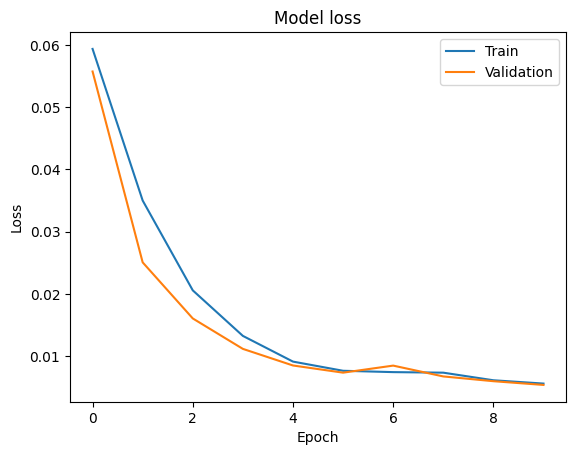

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_pred= autoencoder14.predict(test)
psnr_test=[]
for i in range(0,100):
  x= psnr(test[i],test_pred[i])
  psnr_test.append(x)

4/4 [==============================] - 28s 7s/step


In [ ]:
import statistics

# Mean_test
mean_value = statistics.mean(psnr_test)
print(f"MeanPSNR of test data: {mean_value}")
# Median_test
median_value = statistics.median(psnr_test)
print(f"MedianPSNR of test data: {median_value}")
# Standard Deviation_test
std_deviation = np.std(psnr_test)
print(f"Standard-DeviationPSNR of test data: {std_deviation}")

MeanPSNR of test data: 36.13479215728033
MedianPSNR of test data: 36.08745212187708
Standard-DeviationPSNR of test data: 1.0218181342284247


In [ ]:
autoencoder14.save_weights('/content/drive/MyDrive/Colab Notebooks/TryingDiffArch2/arch14.h5')         # repo contains the weights of the model

## 16x16x8: with Conv 1x1
(16x16x1 : 256 in bottleneck)

In [ ]:
# Input layer for 256x256x3 images
input_img = Input(shape=(256, 256, 3))

# Encoder
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
p1 = MaxPooling2D((2, 2), padding='same')(x1)


x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
p2 = MaxPooling2D((2, 2), padding='same')(x2)


x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
p3 = MaxPooling2D((2, 2), padding='same')(x3)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)    #learning even further
x4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)

#bottleneck
encoded = MaxPooling2D((2, 2), padding='same')(x4)

# 1x1 Conv layer
x1x1= Conv2D(1,(1,1),activation='relu',padding='same')(encoded)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x1x1)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x4], axis=-1)  # Adding skip connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x3], axis=-1)  # Adding skip connection
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x2], axis=-1)  # Adding skip connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x1], axis=-1)  # Adding skip connection
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder16 = Model(input_img,decoded)
autoencoder16.compile(optimizer='adam', loss='mse')
autoencoder16.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_97 (Conv2D)          (None, 256, 256, 32)         896       ['input_9[0][0]']             
                                                                                                  
 conv2d_98 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_97[0][0]']           
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 128, 128, 32)         0         ['conv2d_98[0][0]']           
 ng2D)                                                                                      

In [ ]:
history= autoencoder16.fit(train, train, epochs=10, batch_size=12, validation_data=(val, val))

Epoch 1/10
13/13 [==============================] - 146s 11s/step - loss: 0.0636 - val_loss: 0.0638
Epoch 2/10
13/13 [==============================] - 139s 11s/step - loss: 0.0446 - val_loss: 0.0265
Epoch 3/10
13/13 [==============================] - 137s 11s/step - loss: 0.0227 - val_loss: 0.0158
Epoch 4/10
13/13 [==============================] - 142s 11s/step - loss: 0.0133 - val_loss: 0.0117
Epoch 5/10
13/13 [==============================] - 137s 11s/step - loss: 0.0098 - val_loss: 0.0101
Epoch 6/10
13/13 [==============================] - 137s 11s/step - loss: 0.0082 - val_loss: 0.0087
Epoch 7/10
13/13 [==============================] - 138s 11s/step - loss: 0.0073 - val_loss: 0.0067
Epoch 8/10
13/13 [==============================] - 140s 11s/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/10
13/13 [==============================] - 139s 11s/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/10
13/13 [==============================] - 136s 11s/step - loss: 0.0048 - val_loss: 0.0048

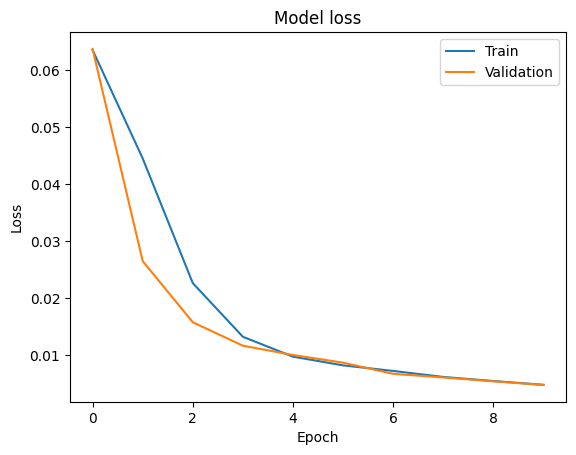

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_pred= autoencoder16.predict(test)
psnr_test=[]
for i in range(0,100):
  x= psnr(test[i],test_pred[i])
  psnr_test.append(x)

4/4 [==============================] - 43s 10s/step


In [ ]:
import statistics

# Mean_test
mean_value = statistics.mean(psnr_test)
print(f"MeanPSNR of test data: {mean_value}")
# Median_test
median_value = statistics.median(psnr_test)
print(f"MedianPSNR of test data: {median_value}")
# Standard Deviation_test
std_deviation = np.std(psnr_test)
print(f"Standard-DeviationPSNR of test data: {std_deviation}")

MeanPSNR of test data: 36.03764711130968
MedianPSNR of test data: 35.89103796680377
Standard-DeviationPSNR of test data: 1.1565666282944786


In [ ]:
autoencoder16.save_weights('/content/drive/MyDrive/Colab Notebooks/TryingDiffArch2/arch16.h5')        # repo contains the weights of the model

## 8x8x8: with Conv 1x1
(8x8x1 : 64 in bottleneck)

In [ ]:
# Input layer for 256x256x3 images
input_img = Input(shape=(256, 256, 3))

# Encoder
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
p1 = MaxPooling2D((2, 2), padding='same')(x1)


x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
p2 = MaxPooling2D((2, 2), padding='same')(x2)


x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
p3 = MaxPooling2D((2, 2), padding='same')(x3)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
p4 = MaxPooling2D((2, 2), padding='same')(x4)

x5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
x5 = Conv2D(8, (3, 3), activation='relu', padding='same')(x5)

#bottleneck
encoded = MaxPooling2D((2, 2), padding='same')(x5)

# 1x1 Conv
x1x1= Conv2D(1, (1,1), activation='relu', padding='same')(encoded)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x1x1)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x5], axis=-1)  # Adding skip connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x4], axis=-1)  # Adding skip connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x3], axis=-1)  # Adding skip connection
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x2], axis=-1)  # Adding skip connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = concatenate([x, x1], axis=-1)  # Adding skip connection
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder18 = Model(input_img,decoded)
autoencoder18.compile(optimizer='adam', loss='mse')
autoencoder18.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
history= autoencoder18.fit(train, train, epochs=10, batch_size=12, validation_data=(val, val))

Epoch 1/10
13/13 [==============================] - 242s 17s/step - loss: 0.0508 - val_loss: 0.0347
Epoch 2/10
13/13 [==============================] - 151s 12s/step - loss: 0.0309 - val_loss: 0.0200
Epoch 3/10
13/13 [==============================] - 166s 13s/step - loss: 0.0161 - val_loss: 0.0132
Epoch 4/10
13/13 [==============================] - 163s 13s/step - loss: 0.0106 - val_loss: 0.0092
Epoch 5/10
13/13 [==============================] - 154s 12s/step - loss: 0.0080 - val_loss: 0.0073
Epoch 6/10
13/13 [==============================] - 153s 12s/step - loss: 0.0070 - val_loss: 0.0065
Epoch 7/10
13/13 [==============================] - 151s 12s/step - loss: 0.0055 - val_loss: 0.0049
Epoch 8/10
13/13 [==============================] - 154s 12s/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/10
13/13 [==============================] - 161s 12s/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/10
13/13 [==============================] - 164s 13s/step - loss: 0.0035 - val_loss: 0.0028

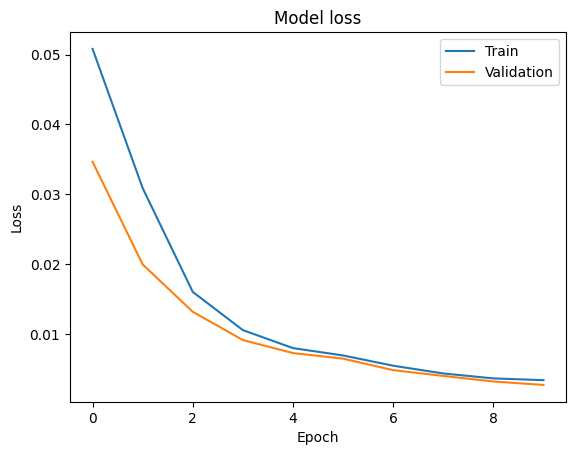

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_pred= autoencoder18.predict(test)
psnr_test=[]
for i in range(0,100):
  x= psnr(test[i],test_pred[i])
  psnr_test.append(x)

4/4 [==============================] - 28s 6s/step


In [ ]:
import statistics

# Mean_test
mean_value = statistics.mean(psnr_test)
print(f"MeanPSNR of test data: {mean_value}")
# Median_test
median_value = statistics.median(psnr_test)
print(f"MedianPSNR of test data: {median_value}")
# Standard Deviation_test
std_deviation = np.std(psnr_test)
print(f"Standard-DeviationPSNR of test data: {std_deviation}")

MeanPSNR of test data: 37.15222838373802
MedianPSNR of test data: 37.04683025949657
Standard-DeviationPSNR of test data: 1.1384521257955986


In [ ]:
autoencoder18.save_weights('/content/drive/MyDrive/Colab Notebooks/TryingDiffArch2/arch18.h5')           # repo contains the weights of the model